## Hypothesis testing 1:

* H0 (Null) - Global temperatures are stable since 1990.
* Ha (alternate) - Global Temperatures are rising on average since 1990. Forbes article (https://www.forbes.com/sites/peterferrara/2012/05/31/sorry-global-warming-alarmists-the-earth-is-cooling/#7e44f66f3de0)


* dataset1 = average temperatures 1990
* dataset2 = average temperatures 2010


* H0 = Mean (dataset 2) - Mean (dataset 1) = 0
* Ha = Mean (dataset 2) - Mean (dataset 1) >= 0


### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [53]:
from scipy.stats import ttest_rel

### Load and transform datasets

In [17]:
# load dataset
df = pd.read_csv('../data/ADS_project_dataset2.csv', header=0, parse_dates=[0], squeeze=True)

In [22]:
# get temperature of countries in 1990
temp1990 = df[df.Year == 1990].reset_index()['AveTemperature']

In [23]:
# get temperature of countries in 2010
temp2010 = df[df.Year == 2010].reset_index()['AveTemperature']

In [69]:
# get describtive statistics
df[df.Year.isin(['1990', '2010'])] \
    .loc[:, ['Country','Year','AveTemperature']] \
    .pivot(index='Country', columns='Year', values='AveTemperature') \
    .describe()

Year,1990,2010
count,175.000000,175.000000
mean,19.228679,19.568906
std,8.504427,8.866892
min,-17.870333,-15.085750
25%,12.012250,11.863583
50%,22.541500,22.730167
75%,26.317417,26.796750
max,29.321083,30.127083


### Visualization

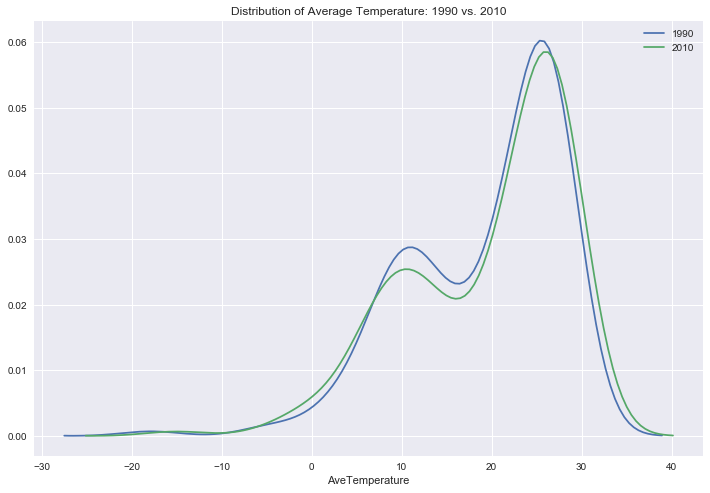

In [51]:
# compare distribution of temperatures in 1990 and 2010
plt.title('Distribution of Average Temperature: 1990 vs. 2010')
plt.figure(figsize=(12,8))
sns.distplot(temp1990, hist=False, label='1990')
sns.distplot(temp2010, hist=False, label='2010');

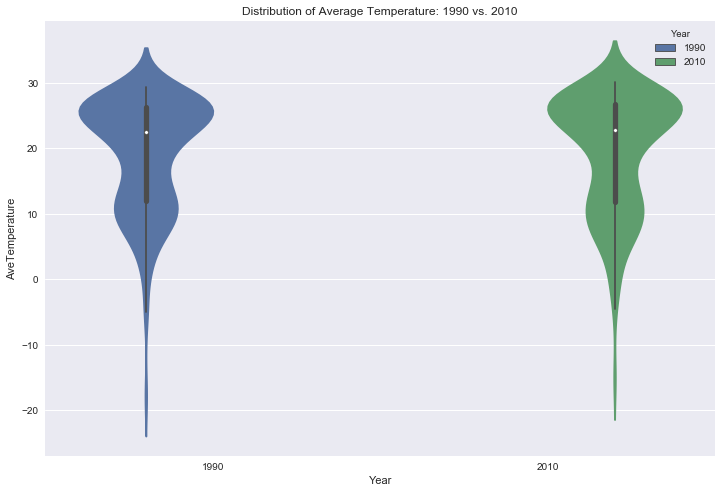

In [50]:
# compare distribution of temperatures in 1990 and 2010
plt.figure(figsize=(12,8))
plt.title('Distribution of Average Temperature: 1990 vs. 2010')
df_violin = df[df.Year.isin([1990, 2010])].loc[:,['Year', 'AveTemperature']]
sns.violinplot(x='Year', y='AveTemperature', hue='Year', data=df_violin);

### Hypothesis Test

In [56]:
# perform paired t-test
ttest_rel(temp2010, temp1990)

Ttest_relResult(statistic=4.706293055988192, pvalue=5.1263233703392395e-06)

** FINDINGS: **
* The observed p-value is significantly less than 0.025 and we reject null hypothesis that average temperatures in 1990 is equal to average temperatures in 2010.
* The positive t-statistic of 4.70 indicates that global Temperatures are rising on average since 1990.